## 주니어

1. 레버 환경 만들기  
2. 카트폴 예제 -- 속도 개선, 학습 가능하게 만들기  
3. 매직 넘버 줄이기
4. 중간 중간 디버깅하면서 가기(구현 단위 별로 테스트)

### 1. 레버 환경 만들기

3개의 레버가 있다.  
- 1번 레버를 당겼을 때 바나나가 떨어질 확률이 0.7, 아무 것도 떨어지지 않을 확률이 0.3  
- 2번 레버를 당겼을 때 바나나가 떨어질 확률이 0.1, 상한 바나나 껍질만 떨어질 확률이 0.8, 아무 것도 떨어지지 않을 확률이 0.1  
- 3번 레버를 당겼을 때 상한 바나나 껍질만 떨어질 확률이 0.5, 아무 것도 떨어지지 않을 확률이 0.5  



1. 상태를 표현하는 방법   
2. 보상 구조 설계  
3. 한 번 행동 한 후 초기화하는 걸 전제    
4. 환경 로직 설계

In [31]:
# 썩은 바나나 -5
# 아무 것도 없는 바나나 0
# 좋은 바나나 1

In [32]:
# 강화 학습을 위한 시뮬레이션 환경을 구현하는 데 중요한 함수가 세 개 있습니다.

# step() 함수: 에이전트에 명령을 내리는 함수입니다. 따라서 가장 많이 호출되는 함수로, 이 함수로 행동 명령을 보내고 환경에서 관찰 변수, 보상 및 게임 종료 여부 등 변수를 반환합니다.

# reset() 함수: 환경을 초기화할 때 사용합니다. 에이전트가 게임을 시작하거나 초기화가 필요할 때 reset() 함수를 사용하며, 초기화될 때는 관찰 변수(상태를 관찰하고 그 정보를 저장)를 함께 반환합니다.

# render() 함수: 화면에 상태를 표시하는 역할을 합니다.

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque

In [34]:
class LeverEnv:

    def __init__(self):
        self.action_space = 3  # 3개의 레버가 있음
        self.state = self.reset()  # 초기 상태로 설정
        self.rewards = {
            'banana': 1.0,               # 좋은 바나나
            'rotten_banana_peel': -5.0,  # 썩은 바나나
            'nothing': 0.0               # 아무것도 없음
        }

    def step(self, action):
        # 확률 범위를 설정해 각 레버의 결과를 구분
        if action == 0:  # 1번 레버
            rand = random.random()
            if rand < 0.7:
                outcome = 'banana'
            else:
                outcome = 'nothing'

        elif action == 1:  # 2번 레버
            rand = random.random()
            if rand < 0.1:
                outcome = 'banana'
            elif rand < 0.9:
                outcome = 'rotten_banana_peel'
            else:
                outcome = 'nothing'

        elif action == 2:  # 3번 레버
            rand = random.random()
            if rand < 0.5:
                outcome = 'rotten_banana_peel'
            else:
                outcome = 'nothing'

        # 보상 체계에 따른 보상 반환
        reward = self.rewards[outcome]

        # 상태를 표시 (좋은 바나나, 썩은 바나나, 아무것도 없음)
        if outcome == 'banana':
            self.state = [1, 0, 0]  # 좋은 바나나
        elif outcome == 'rotten_banana_peel':
            self.state = [0, 1, 0]  # 썩은 바나나
        else:
            self.state = [0, 0, 1]  # 아무것도 없음

        # 게임 종료 여부
        done = False  # 에이전트가 매번 액션 후 종료할 필요가 없기 때문
        info = {"outcome": outcome} # Outcome 결과 저장 딕셔너리

        return torch.tensor(self.state, dtype=torch.float32), reward, done, info



    # 에이전트가 새 에피소드를 시작할 때 호출하는 메서드
    def reset(self):
        # 초기 상태 설정: 아무것도 없는 상태로 초기화
        self.state = [0, 0, 1]
        return torch.tensor(self.state, dtype=torch.float32) # 초기 상태를 텐서로 전환


    # 현재 상태를 출력하는 메서드
    def render(self):
        outcome_map = {0: "좋은 바나나", 1: "썩은 바나나", 2: "아무것도 없음"}
        current_state = outcome_map[self.state.index(1)] # 현재 상태에서 값이 1인 위치를 찾아, 해당하는 결과를 가져옴
        print("Current State:", current_state) # 현재 상태가 [0, 0, 1]이면 "Current State: 아무것도 없음"이 출력


In [35]:
# Q-Network: 상태에 따른 Q 값을 출력하는 신경망
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
      # input_dim: 상태 공간의 크기 (상태 백터[1x3])
      # output_dim: 레버 공간의 크기 (3)
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, output_dim)

    # 각 레버(행동)의 Q값 출력
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [36]:
# DQN 에이전트 정의
class DQNAgent:
    def __init__(self, state_dim, action_dim):

        # 상태와 행동의 크기 정의
        self.state_dim = state_dim
        self.action_dim = action_dim

        # DQN 하이퍼파라미터
        self.gamma = 0.99  # 할인율
        self.epsilon = 1.0  # 탐험 비율 초기값
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001

        # 리플레이 메모리, 최대 크기 2000
        self.memory = deque(maxlen=2000)

        # 모델과 타깃 모델 생성
        self.model = QNetwork(state_dim, action_dim)
        self.target_model = QNetwork(state_dim, action_dim)

        # 타깃 모델 초기화
        self.update_target_model()

        # 신경망 가중치 조정
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

        # MSE 손실 함수 사용
        self.criterion = nn.MSELoss()

    # 모델의 가중치를 타깃 모델로 복사
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

   # 입실론 탐욕 정책으로 행동 선택
    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.randrange(self.action_dim)
        else:
            with torch.no_grad(): # 속도 향상
                return torch.argmax(self.model(state)).item()

    # 샘플을 리플레이 메모리에 저장
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # 미니배치 준비 단계
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        # 메모리에서 배치 크기만큼 무작위로 샘플 추출
        minibatch = random.sample(self.memory, batch_size) # 배치 사이즈만큼 샘플 저장

        # 벨만 방정식에 따라 타깃 Q 값 계산
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                # 다음 상태에 예상되는 최대 보상 추가
                target += self.gamma * torch.max(self.target_model(next_state)).item()

            # 현재 Q 값과 타깃 Q값 간 차이를 구함
            current_q = self.model(state)[action]
            loss = self.criterion(current_q, torch.tensor(target))

            # 신경망 가중치 업데이트
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        # 탐험 비율 감소
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay # 엡실론을 감소시킴


In [37]:
import matplotlib.pyplot as plt

# 학습 환경 설정
env = LeverEnv()
state_dim = 3  # 환경의 상태 차원
action_dim = env.action_space
agent = DQNAgent(state_dim, action_dim)

# DQN 학습
episodes = 500
batch_size = 32

# 각 에피소드의 총 보상 기록
episode_rewards = []

for e in range(episodes):
    state = env.reset()
    total_reward = 0

    for time in range(1):
        # 행동 선택
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)

        # 경험 기록
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward  # 보상 누적

        if done:
            break

    # 리플레이로 에이전트 학습
    agent.replay(batch_size)

    # 각 에피소드마다 타겟 모델 업데이트
    if e % 10 == 0:
        agent.update_target_model()

    # 에피소드 결과 출력
    print(f"Episode {e+1}/{episodes}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")
    episode_rewards.append(total_reward)  # 에피소드 총 보상 저장


Episode 1/500, Total Reward: 1.0, Epsilon: 1.00
Episode 2/500, Total Reward: 1.0, Epsilon: 1.00
Episode 3/500, Total Reward: 1.0, Epsilon: 1.00
Episode 4/500, Total Reward: 1.0, Epsilon: 1.00
Episode 5/500, Total Reward: 0.0, Epsilon: 1.00
Episode 6/500, Total Reward: 0.0, Epsilon: 1.00
Episode 7/500, Total Reward: 0.0, Epsilon: 1.00
Episode 8/500, Total Reward: -5.0, Epsilon: 1.00
Episode 9/500, Total Reward: -5.0, Epsilon: 1.00
Episode 10/500, Total Reward: 0.0, Epsilon: 1.00
Episode 11/500, Total Reward: 1.0, Epsilon: 1.00
Episode 12/500, Total Reward: 1.0, Epsilon: 1.00
Episode 13/500, Total Reward: 0.0, Epsilon: 1.00
Episode 14/500, Total Reward: -5.0, Epsilon: 1.00
Episode 15/500, Total Reward: 0.0, Epsilon: 1.00
Episode 16/500, Total Reward: 0.0, Epsilon: 1.00
Episode 17/500, Total Reward: 1.0, Epsilon: 1.00
Episode 18/500, Total Reward: 0.0, Epsilon: 1.00
Episode 19/500, Total Reward: -5.0, Epsilon: 1.00
Episode 20/500, Total Reward: -5.0, Epsilon: 1.00
Episode 21/500, Total Re

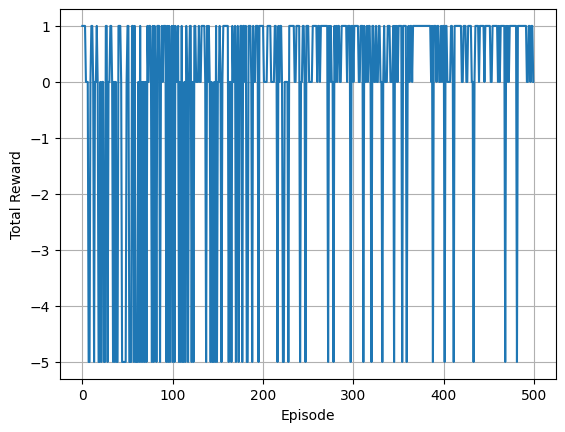

In [38]:
# 에피소드마다 학습 결과 그래프로 저장
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.show()

## 과제
1. 완성해오기(설명가능한 상태로 ipynb 파일 구성)    
2. 알파제로 구조 공부해오기(전원)  
3. 자기 코드 규칙 정리해오기